## Comparison of batches 6 & 7: exploring heterozygosity

<br>
In batch 6 (haplotypes), I plotted heteryzogosity against read depth and ended up with several individuals with extremely high heterozygosity. 

For the same plot in batch 7 (random snps), I do not have any individuals with observed heterozygosities above 0.20. 

I think that this has something to do with using the haplotypes v. random snps method after `populations`, so I am going to... 
1. BLAST the batches 6 and 7 catalogs against each other to correlate loci names
2. Create a dictionary with batch 7 loci names as the key, and batch 6 loci names as the value. 
3. Choose a subset of individuals
4. Create a  list of loci that are missing genotypes in each individual
5. Find those loci in the batch 6 and see if they are also missing, called as heterozygotes, or called as homozygotes. 

#### 9/18/2017

### BLAST catalogs from batch 6 and batch 7

<br>
#### Create FASTA files from each catalog

In [1]:
cd ../analyses

/mnt/hgfs/Pacific cod/DataAnalysis/PCod-Korea-repo/analyses


In [2]:
cd batch6_v_batch7/

/mnt/hgfs/Pacific cod/DataAnalysis/PCod-Korea-repo/analyses/batch6_v_batch7


In [4]:
## Create FASTA from catalog.tags.tsv file: ##

infile = open("batch_6.catalog.tags.tsv", "r")
outfile = open("batch_6_catalog.fa", "w")

for line in infile:
    if not line.startswith("#"):
        linelist = line.strip().split()
        locus = linelist[3]
        seq = linelist[9]
        outfile.write(">" + locus + "\n" + seq + "\n")
infile.close()
outfile.close()

In [5]:
## Create FASTA from catalog.tags.tsv file: ##

infile = open("batch_7.catalog.tags.tsv", "r")
outfile = open("batch_7_catalog.fa", "w")

for line in infile:
    if not line.startswith("#"):
        linelist = line.strip().split()
        locus = linelist[3]
        seq = linelist[9]
        outfile.write(">" + locus + "\n" + seq + "\n")
infile.close()
outfile.close()

#### Create BLAST database out of batch 7 catalog fasta file

In [6]:
!makeblastdb -in batch_7_catalog.fa \
-parse_seqids \
-dbtype nucl \
-out batch_7_catalogDB



Building a new DB, current time: 09/18/2017 18:51:39
New DB name:   /mnt/hgfs/Pacific cod/DataAnalysis/PCod-Korea-repo/analyses/batch6_v_batch7/batch_7_catalogDB
New DB title:  batch_7_catalog.fa
Sequence type: Nucleotide
Keep Linkouts: T
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 25224 sequences in 1.20668 seconds.


In [9]:
!blastn -query batch_6_catalog.fa \
-db batch_7_catalogDB \
-out batch_6_BLASTto_batch_7_cat \
-outfmt 6

### Create dictionary for loci that match between batches 6 & 7

In [10]:
## create a list of reference loci that have only one alignment in batch 6 data ##
infile = open("batch_6_BLASTto_batch_7_cat", "r")
unique_loci = []
duplicates = 0
batch7to6_dict = {}

for line in infile:
    ref_locus = line.strip().split()[1]
    if ref_locus not in unique_loci:
        unique_loci.append(ref_locus)
        batch7to6_dict[ref_locus] = line.strip().split()[0]
    elif ref_locus in unique_loci:
        duplicates += 1
infile.close()
print len(unique_loci), " reference loci aligned to only one batch 6 locus"
print "there were ", duplicates, " duplicates"

24912  reference loci aligned to only one batch 6 locus
there were  28014  duplicates


In [12]:
outfile = open("batch7_unique_refloci.txt", "w")
for locus in batch7to6_dict.keys():
    outfile.write(locus + "\t" + batch7to6_dict[locus] + "\n")
outfile.close()

#### 9/19/2017

In [1]:
cd ../analyses/batch6_v_batch7/

/mnt/hgfs/Pacific cod/DataAnalysis/PCod-Korea-repo/analyses/batch6_v_batch7


In [3]:
# read back in loci for dictionary #
infile = open("batch7_unique_refloci.txt", "r")
batch7to6_dict = {}
for line in infile:
    locus7 = line.strip().split()[0]
    locus6 = line.strip().split()[1]
    batch7to6_dict[locus7] = locus6
infile.close()

### Select a subset of individuals

In [4]:
import random
individs_index = random.sample(xrange(299), 25)
subset = []
popmap = open("../../scripts/PopMap_L1-5_mdFilter_b7.txt", "r")
index = 0
for line in popmap:
    if index in individs_index:
        subset.append(line.strip().split()[0])
        index += 1
    elif index not in individs_index:
        index += 1
popmap.close()

In [5]:
print subset

['PO010715_08.1', 'PO020515_05.1', 'PO020515_08.1', 'GE011215_01.1', 'GE011215_07.1', 'GE011215_18', 'GE011215_28', 'GE012315_17.1', 'GEO012315_18', 'NA021015_21.1', 'YS121315_12', 'JUK07_03', 'JUK07_14', 'JUK07_21', 'JUK07_34', 'JB121807_05_2', 'JB021108_05_rep', 'JB021108_09.1', 'JB021108_25.1', 'JB021108_23', 'BOR07_07.1', 'BOR07_15', 'BOR07_22', 'GEO020414_15', 'GEO020414_9']


### Find loci in those individuals that are NOT genotyped in batch 7

In [10]:
## create a dictionary that lists loci missing genotypes in batch 7. key is individual name ##
genos_missing_dict = {}

for sample in subset:
    genepop = open("../../stacks_b7_wgenome/batch_7.filteredLoci20_filteredMAF_filteredIndivids_filteredHWE.txt", "r")
    header = genepop.readline().split("\t")
    index = 0
    for i in header:
        if i == sample:
            break
        else:
            index += 1
    genos_missing_list = []
    for line in genepop:
        linelist = line.strip().split()
        locus = linelist[0].split("_")[0]
        genotype = linelist[index]
        if genotype == "0000":
            genos_missing_list.append(locus)
    genos_missing_dict[sample] = genos_missing_list
    genepop.close()


In [11]:
print genos_missing_dict['PO010715_08.1']

['1610', '3902', '4319', '4325', '5755', '6422', '8177', '10357', '10550', '11860', '12119', '12243', '12753', '15183', '15977', '17293', '17991', '18011', '18621', '18800', '19855', '20095', '21169', '21603', '21960', '21974', '22009', '22515', '23086', '23365', '24213', '24801']


### Determine genotypes in those loci for batch 6

#### Find the corresponding batch 6 loci for loci NOT genotyped in batch 7 
(note that not all loci missing genotypes in batch 7 were present in batch 6)

In [16]:
## create a dictionary that lists corresponding batch 6 locus for loci missing genos in batch 7 ##
### key is still individual name ###
genos_missing_b6loci_dict = {} #for loci that have a match in batch 6, save batch 6 loci name
genos_missing_nob6loci_dict = {} #for loci that do NOT have a match in batch 6, save batch 7 loci name
for sample in subset:
    batch7_loci = genos_missing_dict[sample]
    batch6_loci = []
    batch7_nob6_loci = []
    for locus in batch7_loci:
        if locus in batch7to6_dict.keys():
            locusb6 = batch7to6_dict[locus]
            batch6_loci.append(locusb6)
        elif locus not in batch7to6_dict.keys():
            batch7_nob6_loci.append(locus)
    genos_missing_b6loci_dict[sample] = batch6_loci
    genos_missing_nob6loci_dict[sample] = batch7_nob6_loci

In [17]:
print genos_missing_b6loci_dict['PO010715_08.1']
print genos_missing_nob6loci_dict['PO010715_08.1']

['4319', '6422', '8177', '10357', '10550', '11860', '12119', '11128', '12753', '15183', '17293', '17991', '18011', '18800', '19855', '21169', '21974', '22009', '23365', '24213', '24801']
['1610', '3902', '4325', '5755', '15977', '18621', '20095', '21603', '21960', '22515', '23086']


In [24]:
## create a dictionary that lists genotypes for loci in genos_missing_b6loci_dict ##
### key is still individual name ###
subset_2 = []
genepop = open("../../stacks_b6_wgenome/batch_6.filteredMAF_filteredLoci_20filteredIndivids_filteredHWE.txt", "r")
header = genepop.readline().split("\t")
genepop.close()
count = 0 
for sample in subset:
    if sample in header:
        subset_2.append(sample)
        count += 1
print "sample size: ", count
    
genotypes_b6_b7missing_dict = {}
for sample in subset_2:
    genepop = open("../../stacks_b6_wgenome/batch_6.filteredMAF_filteredLoci_20filteredIndivids_filteredHWE.txt", "r")
    header = genepop.readline().split("\t")
    index = 0
    for i in header:
        if i == sample:
            break
        else:
            index += 1
    genos_list = []
    for line in genepop:
        linelist = line.strip().split()
        locus = linelist[0].split("_")[0]
        if locus in genos_missing_b6loci_dict[sample]:
            genos_list.append(linelist[index])
    genotypes_b6_b7missing_dict[sample] = genos_list
    genepop.close()

sample size:  20


In [25]:
print genotypes_b6_b7missing_dict['PO010715_08.1']

['0202', '0202', '0202']


**At first, I was confused about why I have more loci matched between b6 and b7 (previous step) than genotypes, but I'm assuming that it is because certain catalog loci were filtered out by the final genepop.**

In [29]:
## Create list of just genotypes from batch 6 ###
b6_genos_all = []
for sample in subset_2:
    if len(genotypes_b6_b7missing_dict[sample]) > 0:
        for i in genotypes_b6_b7missing_dict[sample]:
            b6_genos_all.append(i)

### Compare heterozygotes, homozygotes, missing

In [30]:
import numpy as np
import matplotlib.pyplot as plt

In [38]:
het = []
hom = []
missing = []
for geno in b6_genos_all:
    if geno == "0101" or geno == "0202":
        hom.append(geno)
    elif geno == "0102":
        het.append(geno)
    elif geno == "0000":
        missing.append(geno)

In [39]:
print len(het), " Heterozygotes in batch 6"
print len(hom), " Homozygotes in batch 6"
print len(missing), " Genotypes Missing in batch 6"

43  Heterozygotes in batch 6
195  Homozygotes in batch 6
16  Genotypes Missing in batch 6


<br>
<br>

### Potential explanations:

1. In batch 7, I have filtered out the loci that were heterozygous in batch 6 "contaminated" individuals
2. The loci in batch 6 that were considered heterozygous in "contaminated" individuals were undersplit - so they matched to 1+ locus in the BLAST comparison, and the corresponding multiple batch 7 loci are homozygous??


<br>
<br>

## Comparison of batches 6 & 7: exploring heterozygosity P2

What proportion of the matching loci between batches 6 & 7 are heterozygous in batch 6, but not in batch 7? FOR BATCH 6 CONTAMINATED INDIVIDUALS

1. Find genotypes of matching loci for contaminated individuals, batch 6. Find proportion heterozygous
2. Find genotypes of corresponding loci for contaminated individuals, batch 7. Find proportion heterozygous

In [60]:
## I already have my dictionary to match loci ##

## The following code identifies genotypes of matched batch 6 loci for "contaminated" individuals ##

# keep the matching loci that show up in the final genotyped files ONLY #
b6_filtered = []
infile = open("../../stacks_b6_wgenome/batch_6.filteredMAF_filteredLoci_20filteredIndivids_filteredHWE.txt", "r")
infile.readline()
for line in infile:
    if not line.startswith("sample"):
        b6_filtered.append(line.strip().split()[0])
infile.close

b7_filtered = []
infile = open("../../stacks_b7_wgenome/batch_7.filteredLoci20_filteredMAF_filteredIndivids_filteredHWE.txt", "r")
infile.readline()
for line in infile:
    if not line.startswith("sample"):
        b7_filtered.append(line.strip().split()[0].split("_")[0])
infile.close


retained_matching_loci = {}
retained_matching_locib6 = []
matching_loci_b6_only = []
for locus in batch7to6_dict.keys():
    if locus in b7_filtered and batch7to6_dict[locus] in b6_filtered:
        retained_matching_loci[locus] = batch7to6_dict[locus]
        retained_matching_locib6.append(batch7to6_dict[locus])
    elif batch7to6_dict[locus] in b6_filtered and locus not in b7_filtered:
        matching_loci_b6_only.append(batch7to6_dict[locus])

In [59]:
print len(retained_matching_locib6)

754


In [61]:
print len(matching_loci_b6_only)

3357


In [70]:
contam = ['GE011215_08.1', 'GE012315_11.1', 'GE012315_09.1', 'NA021015_09.1', 'NA021015_10.1', 'NA021015_06.1', 'PO010715_26', 'YS_121316_20.1', 'YS121315_14.1', 'BOR07_10.1', 'YS_121316_05', 'JUK07_06.1']

p_het6_only = []
p_het6_matched = []

for sample in contam:
    #batch 6
    het6_only = 0
    genotyped6_only = 0
    het6_matched = 0
    genotyped6_matched = 0
    genepop6 = open("../../stacks_b6_wgenome/batch_6.filteredMAF_filteredLoci_20filteredIndivids_filteredHWE.txt", "r")
    header = genepop6.readline().split("\t")
    index = 0
    for i in header:
        if i == sample:
            break
        else:
            index += 1
    print sample
    print index
    genotypes_b6_matched = []
    genotypes_b6_only = []
    for line in genepop6:
        linelist = line.strip().split()
        locus = linelist[0].split("_")[0]
        if locus in retained_matching_locib6:
            genotypes_b6_matched.append(linelist[index])
        elif locus in matching_loci_b6_only:
            genotypes_b6_only.append(linelist[index])
    #calculate heterozygosities
    n_gen6_only = len([i for i in genotypes_b6_only if i != "0000"])
    n_het6_only = len([i for i in genotypes_b6_only if i == "0102"])
    n_gen6_matched = len([i for i in genotypes_b6_matched if i != "0000"])
    n_het6_matched = len([i for i in genotypes_b6_matched if i == "0102"])
    
    p_het6_only.append(float(n_het6_only)/float(n_gen6_only))
    p_het6_matched.append(float(n_het6_matched)/float(n_gen6_matched))

GE011215_08.1
34
GE012315_11.1
57
GE012315_09.1
55
NA021015_09.1
69
NA021015_10.1
70
NA021015_06.1
67
PO010715_26
11
YS_121316_20.1
87
YS121315_14.1
101
BOR07_10.1
193
YS_121316_05
83
JUK07_06.1
109


In [76]:
print "batch6 only\tmatched loci"
for i in range(0, len(p_het6_only)):
    print p_het6_only[i], "\t", p_het6_matched[i]

batch6 only	matched loci
0.24112961622 	0.26
0.31067961165 	0.339335180055
0.349895760945 	0.378303198887
0.287552155772 	0.287899860918
0.273393854749 	0.283727399166
0.274468826193 	0.291492329149
0.274496177901 	0.285318559557
0.277642134636 	0.260869565217
0.290616246499 	0.309423347398
0.319468717232 	0.329113924051
0.228715728716 	0.263532763533
0.236951983299 	0.23928077455


### Conclusions...

It doesn't look like the loci that were retained in batch 6 and filtered out in batch 7 have a very different heterozygosity than those retained in both batches. So it (likely) doesn't have much to do with the loci that are being retained, but rather the way that they are being genotyped.

<br>
<br>
<br>
<br>

## Comparison of batches 6 & 7: exploring heterozygosity P3

Comparing read depth at loci that are shared v. batch 6 only (read depth calculated from batch 6 files). 

In order to run this, I will need to make sure that the following objects are saved:
1. retained_matching_locib6
2. matching_loci_b6_only
3. batch7to6_dict


### Read depth at Loci that are batch 6 only

In [2]:
pwd

u'/mnt/hgfs/Pacific cod/DataAnalysis/PCod-Korea-repo/notebooks'

In [3]:
cd ../analyses/batch6_v_batch7/

/mnt/hgfs/Pacific cod/DataAnalysis/PCod-Korea-repo/analyses/batch6_v_batch7


In [4]:
# read back in loci for dictionary #
infile = open("batch7_unique_refloci.txt", "r")
batch7to6_dict = {}
for line in infile:
    locus7 = line.strip().split()[0]
    locus6 = line.strip().split()[1]
    batch7to6_dict[locus7] = locus6
infile.close()

In [5]:
## The following code identifies genotypes of matched batch 6 loci for "contaminated" individuals ##

# keep the matching loci that show up in the final genotyped files ONLY #
b6_filtered = []
infile = open("../../stacks_b6_wgenome/batch_6.filteredMAF_filteredLoci_20filteredIndivids_filteredHWE.txt", "r")
infile.readline()
for line in infile:
    if not line.startswith("sample"):
        b6_filtered.append(line.strip().split()[0])
infile.close

b7_filtered = []
infile = open("../../stacks_b7_wgenome/batch_7.filteredLoci20_filteredMAF_filteredIndivids_filteredHWE.txt", "r")
infile.readline()
for line in infile:
    if not line.startswith("sample"):
        b7_filtered.append(line.strip().split()[0].split("_")[0])
infile.close


retained_matching_loci = {}
retained_matching_locib6 = []
matching_loci_b6_only = []
for locus in batch7to6_dict.keys():
    if locus in b7_filtered and batch7to6_dict[locus] in b6_filtered:
        retained_matching_loci[locus] = batch7to6_dict[locus]
        retained_matching_locib6.append(batch7to6_dict[locus])
    elif batch7to6_dict[locus] in b6_filtered and locus not in b7_filtered:
        matching_loci_b6_only.append(batch7to6_dict[locus])

In [7]:
contam = ['GE011215_08.1', 'GE012315_11.1', 'GE012315_09.1', 'NA021015_09.1', 'NA021015_10.1', 'NA021015_06.1', 'PO010715_26', 'YS_121316_20.1', 'YS121315_14.1', 'BOR07_10.1', 'YS_121316_05', 'JUK07_06.1']


In [11]:
b6_only_depth = []
b6_matched_depth = []
outfile = open("stack_depths_b6.txt", "w")
outfile.write("individual\tdepths_matched_loci\tdepths_b6_only_loci\n")

for sample in contam:
    ## find that locus in the matches file and save the total depth to dict.
    mfile = open("../../stacks_b7_wgenome/" + sample + ".matches.tsv", "r")
    loci_depths_matched_dict = {}
    loci_depths_b6only_dict = {}
    for line in mfile:
        if not line.startswith("#"):
            cat_locus = line.strip().split()[2]
            ## If locus is only in b6 ##
            if cat_locus in retained_matching_locib6 and cat_locus not in loci_depths_matched_dict.keys():
                loci_depths_matched_dict[cat_locus] = int(line.strip().split()[6])
            elif cat_locus in retained_matching_locib6 and cat_locus in loci_depths_matched_dict.keys():
                depth = loci_depths_matched_dict[cat_locus]
                depth += int(line.strip().split()[6])
                loci_depths_matched_dict[cat_locus] = depth
            ## if locus is matched b6 and b7 ##
            elif cat_locus in matching_loci_b6_only and cat_locus not in loci_depths_b6only_dict.keys():
                loci_depths_b6only_dict[cat_locus] = int(line.strip().split()[6])
            elif cat_locus in matching_loci_b6_only and cat_locus in loci_depths_b6only_dict.keys():
                depth = loci_depths_b6only_dict[cat_locus]
                depth += int(line.strip().split()[6])
                loci_depths_b6only_dict[cat_locus] = depth
    mfile.close()
    ## append stack depths of loci in this individual to list.
    outfile.write(sample + "\t")
    for locus in loci_depths_matched_dict.keys():
        b6_matched_depth.append(loci_depths_matched_dict[locus])
        outfile.write(str(loci_depths_matched_dict[locus]) + ",")
    outfile.write("\t")
    for locus in loci_depths_b6only_dict.keys():
        b6_only_depth.append((loci_depths_b6only_dict[locus]))
        outfile.write(str(loci_depths_b6only_dict[locus]) + ",")
    outfile.write("\n")
outfile.close()

In [12]:
print b6_only_depth[0:10]

[23, 122, 12, 10, 69, 17, 27, 49, 24, 32]


In [13]:
import numpy as np
import matplotlib.pyplot as plt

In [22]:
data_for_plot = [b6_only_depth, b6_matched_depth]

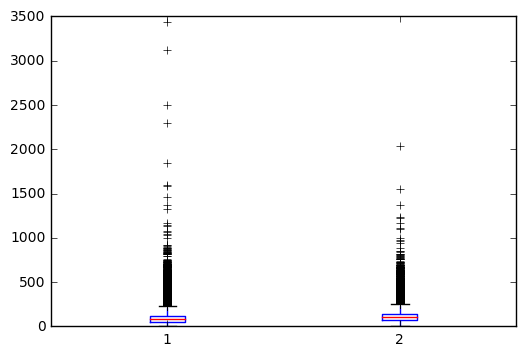

In [23]:
plt.figure()
plt.boxplot(data_for_plot)
plt.show()

In [24]:
plt.close()

In [25]:
b6_only_depth_lt1000 = [i for i in b6_only_depth if i < 1000]
b6_matched_depth_lt1000 = [i for i in b6_matched_depth if i < 1000]

In [26]:
data_for_plot2 = [b6_only_depth_lt1000, b6_matched_depth_lt1000]

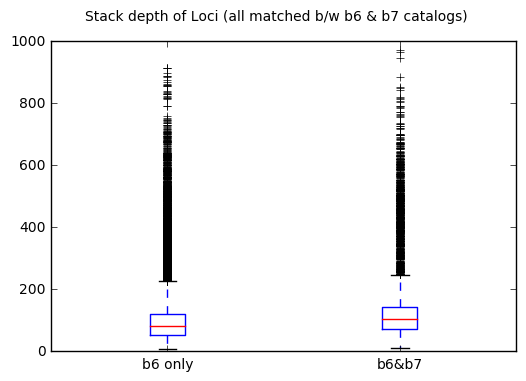

In [30]:
plt.figure()
plt.boxplot(data_for_plot2)
plt.xticks([1,2], ['b6 only', 'b6&b7'])
plt.suptitle("Stack depth of Loci (all matched b/w b6 & b7 catalogs)")
plt.show()

In [31]:
plt.close()